## 

In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True


In [3]:
import sys
sys.path.append('../')


In [4]:
import neptune


In [35]:
# https://docs.neptune.ai/api/project/#fetch_runs_table

project = neptune.init_project(
    project="yuuk1/tsdr",
    mode="read-only",
)
runs_table_df = project.fetch_runs_table(state="inactive").to_pandas()


https://app.neptune.ai/yuuk1/tsdr/


In [36]:
runs_table_df[["experiment_id", "sys/creation_time"]].groupby("experiment_id").min().sort_values("sys/creation_time", ascending=False)


,sys/creation_time
experiment_id,
20231010160515,2023-10-10 07:05:18.787000+00:00
20231006115708,2023-10-06 02:57:12.262000+00:00
20231006014933,2023-10-05 16:49:37.395000+00:00
20230921060302,2023-09-20 21:10:24.142000+00:00
20230919225512,2023-09-19 13:55:15.783000+00:00
...,...
20230410222507,2023-04-10 13:25:11.260000+00:00
20230410145022,2023-04-10 05:50:25.332000+00:00
20230410132132,2023-04-10 04:21:35.395000+00:00


In [37]:
def convert_to_dataset_name(x: pd.Series) -> str:
    match x["dataset/target_app"], x["dataset/metric_types/middlewares"], x["dataset/use_manually_selected_metrics"]:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination:")


In [38]:
target_df = runs_table_df[runs_table_df["sys/failed"] == False].sort_values(by="sys/creation_time")[
    runs_table_df["experiment_id"].isin(["20231006014933", "20231006115708", "20231010160515"])
].filter(
    regex="^sys/id|experiment_id|dataset/.+|parameters/.*|scores/.*",
).dropna(axis=1, how="all")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(target_df)


/tmp/ipykernel_4014995/2884745734.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_df = runs_table_df[runs_table_df["sys/failed"] == False].sort_values(by="sys/creation_time")[


,sys/id,dataset/dataset_id,dataset/metric_types/containers,dataset/metric_types/middlewares,dataset/metric_types/nodes,dataset/metric_types/services,dataset/sampling_scale_factor,dataset/target_app,dataset/time_range/end,dataset/time_range/start,dataset/use_manually_selected_metrics,experiment_id,parameters/enable_multireducer,parameters/enable_unireducer,parameters/step1_changepoint_cost_model,parameters/step1_changepoint_penalty,parameters/step1_changepoint_search_method,parameters/step1_method_name,parameters/step2_changepoint_kde_bandwidth,parameters/step2_changepoint_kde_bandwidth_adjust,parameters/step2_changepoint_segment_selection_method,parameters/step2_clustering_granularity,parameters/step2_clustering_method_name,scores/RS_AC_1,scores/RS_AC_2,scores/RS_AC_3,scores/RS_AC_4,scores/RS_AC_5,scores/RS_AVG_1,scores/RS_AVG_2,scores/RS_AVG_3,scores/RS_AVG_4,scores/RS_AVG_5,scores/accuracy,scores/cause_metrics/bacc_mean,scores/cause_metrics/f1_score_mean,scores/cause_metrics/fn_mean,scores/cause_metrics/fp_mean,scores/cause_metrics/mcc_mean,scores/cause_metrics/num_found_mean,scores/cause_metrics/num_mandatory_found_mean,scores/cause_metrics/num_mandatory_total_mean,scores/cause_metrics/num_total_mean,scores/cause_metrics/precision_mean,scores/cause_metrics/proportion_mandatory_mean,scores/cause_metrics/proportion_mean,scores/cause_metrics/recall_mandatory_mean,scores/cause_metrics/recall_mean,scores/cause_metrics/specificity_mean,scores/cause_metrics/tn_mean,scores/cause_metrics/tp_mean,scores/elapsed_time,scores/elapsed_time_max,scores/elapsed_time_min,scores/fn,scores/mandatory_accuracy,scores/mandatory_fn,scores/mandatory_tp,scores/num_series/containers,scores/num_series/middlewares,scores/num_series/services,scores/num_series/total,scores/reduction_rate_max,scores/reduction_rate_mean,scores/reduction_rate_min,scores/tp
44,TSDR-1837,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,True,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.021328,0.042091,0.062305,0.081985,0.101147,0.021328,0.031710,0.041908,0.051927,0.061771,0.97500,0.595345,0.041557,0.125000,43.525000,0.049133,1.712500,0.875000,1.000000,2.000000,0.021328,0.021328,0.041274,0.875000,0.875000,0.315689,19.925000,0.875000,1.853585,2.4527,1.6209,2.0,0.875000,10.0,70.0,0/0/65,NaN,0/0/15,44/64/80,0.625000,0.312703,0.029851,78.0
43,TSDR-1838,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,False,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.040308,0.078490,0.114687,0.149024,0.181620,0.040308,0.059399,0.077828,0.095627,0.112826,1.00000,0.658396,0.076366,0.725000,95.025000,0.096370,8.550000,3.712500,4.437500,10.550000,0.040308,0.040308,0.098267,0.840625,0.840625,0.476167,85.875000,3.712500,3.646671,4.4450,3.1503,0.0,0.937500,5.0,75.0,0/0/484,NaN,0/0/15,98/185/499,0.741935,0.469407,0.177665,80.0
42,TSDR-1839,9n6mf,True,True,False,True,1.0,sock-shop,0.0,0.0,False,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.008818,0.017537,0.026157,0.034681,0.043109,0.008818,0.013177,0.017504,0.021798,0.026060,1.00000,0.662647,0.017404,1.587500,604.475000,0.045084,10.750000,5.212500,6.800000,14.600000,0.008818,0.008818,0.018720,0.773883,0.773883,0.551412,736.175000,5.212500,19.131758,25.3574,14.9755,0.0,0.962500,3.0,77.0,0/0/484,0/0/6294,0/0/15,609/1347/6793,0.753007,0.549889,0.346074,80.0
41,TSDR-1840,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,True,20231006014933,True,True,l2,bic,pelt,changepoint,0.4,1.0,weighted_max,service,changepoint-kde,0.022927,0.045184,0.066794,0.087777,0.108154,0.022927,0.034056,0.044968,0.055671,0.066167,0.97500,0.611807,0.044557,0.125000,41.437500,0.058351,1.712500,0.875000,1.000000,2.000000,0.022927,0.022927,0.044335,0.875000,0.875000,0.348614,22.012500,0.875000,1.958040,2.4498,1.7140,2.0,0.875000,10.0,70.0,0/0/65,NaN,0/0/15,42/64/80,0.703125,0.345116,0.046154,78.0
40,TSDR-1841,9n6mf,True,False,False,True,

In [39]:
target_df["dataset_name"] = target_df.apply(convert_to_dataset_name, axis=1)


In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    tsdr_results_df = target_df.rename(columns={
        "scores/cause_metrics/bacc_mean": "bacc",
        "scores/cause_metrics/mcc_mean": "mcc",
        "scores/cause_metrics/specificity_mean": "rrate",
        "scores/cause_metrics/recall_mandatory_mean": "recall",
        "scores/cause_metrics/proportion_mandatory_mean": "proportion",
        "scores/cause_metrics/specificity_mandatory_mean": "specificity",
        "scores/elapsed_time": "elapsed_time",
    }).filter(
        regex="^(sys/id|dataset_name|bacc|mcc|rrate|recall|proportion|specificity|elapsed_time)$|search|bandwidth",
        axis=1,
    )
    display(tsdr_results_df)


,sys/id,parameters/step1_changepoint_search_method,parameters/step2_changepoint_kde_bandwidth,parameters/step2_changepoint_kde_bandwidth_adjust,bacc,mcc,proportion,recall,rrate,elapsed_time,dataset_name
44,TSDR-1837,pelt,0.2,1.0,0.595345,0.049133,0.021328,0.875000,0.315689,1.853585,SS-small
43,TSDR-1838,pelt,0.2,1.0,0.658396,0.096370,0.040308,0.840625,0.476167,3.646671,SS-medium
42,TSDR-1839,pelt,0.2,1.0,0.662647,0.045084,0.008818,0.773883,0.551412,19.131758,SS-large
41,TSDR-1840,pelt,0.4,1.0,0.611807,0.058351,0.022927,0.875000,0.348614,1.958040,SS-small
40,TSDR-1841,pelt,0.4,1.0,0.666158,0.102238,0.042188,0.840625,0.491692,3.706541,SS-medium
39,TSDR-1842,pelt,0.4,1.0,0.673574,0.048186,0.008999,0.798778,0.548370,19.170409,SS-large
38,TSDR-1843,pelt,0.6,1.0,0.640605,0.076711,0.024471,0.925000,0.356211,1.979745,SS-small
37,TSDR-1844,pelt,0.6,1.0,0.699343,0.124945,0.044932,0.908333,0.490353,3.743485,SS-medium
36,TSDR-1845,pelt,0.6,1.0,0.705470,0.056554,0.009393,0.889017,0.521924,19.142068,SS-large
35,TSDR-1846,pelt,0.8,1.0,0.661396,0.087903,0.025871,0.975000,0.347791,1.996100,SS-small


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


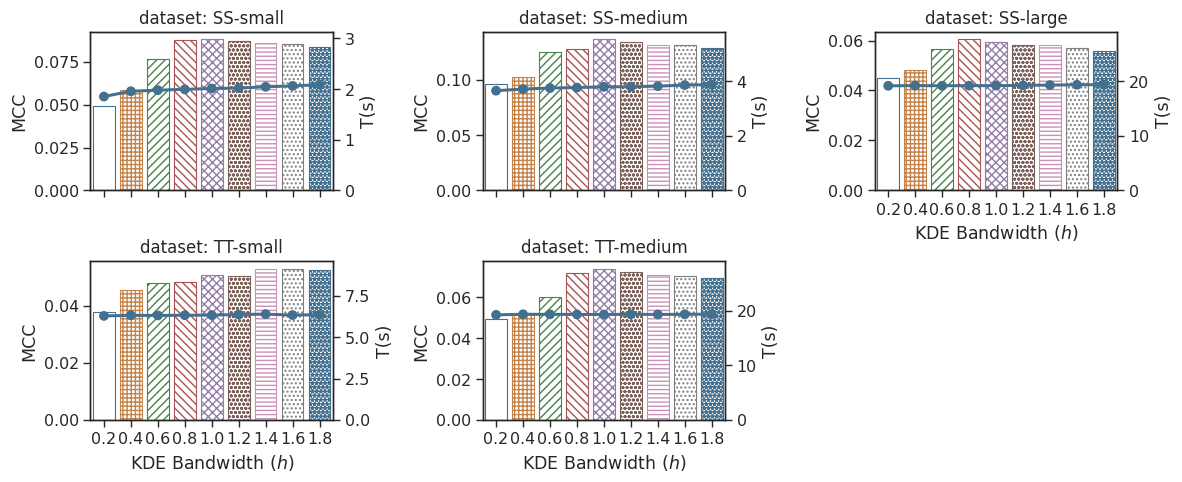

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


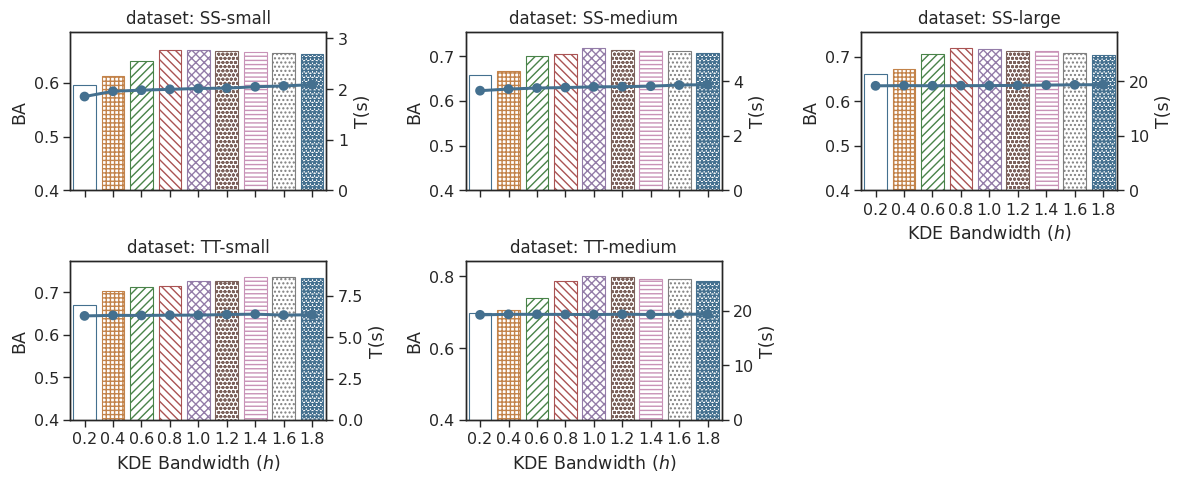

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


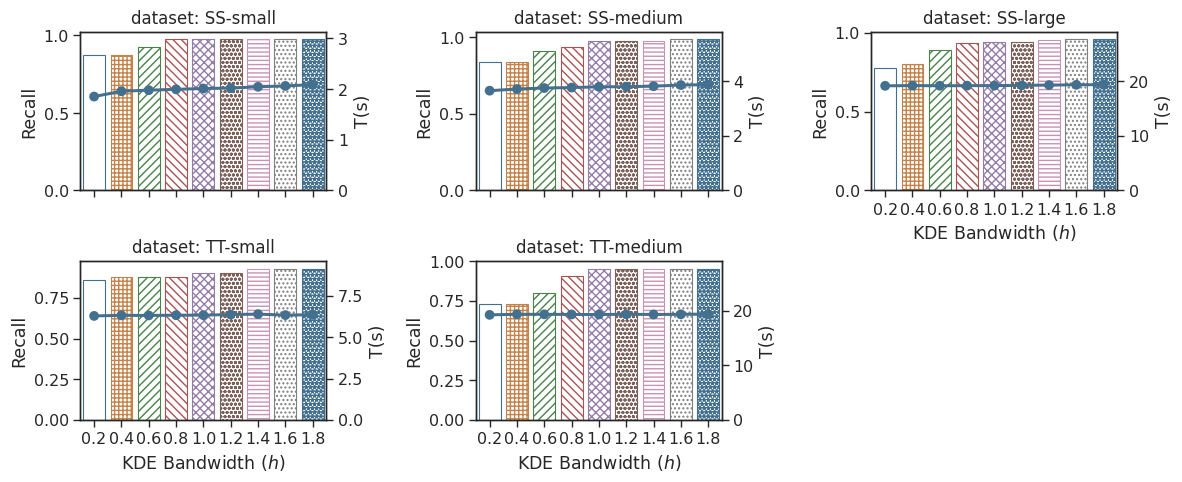

In [48]:
from itertools import cycle
import seaborn as sns

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-R":
            return "HDBS-R"
    return label

def wrap_loc(label):
    return "+\n".join(str(label.get_text()).split("+"))

def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs)):
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, xlabel: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, color: str, label: str):
    ax1 = plt.gca()
    # bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    bar = sns.barplot(
        data=data, x=x_name, y=metric,# hue="combination",
        alpha=1, color="none", fill=None,
        ax=ax1,
    )
    num_bar = len(bar.patches)
    # https://stackoverflow.com/questions/76233164/how-to-add-hatches-to-histplot-bars-and-legend
    hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****", "||||||||", "o-o-o-o-o", "x-x-x-x-x", "+-+-+"]
    # for container, hatch, handle, color in zip(ax.containers, hatchs, ax.get_legend().legend_handles, sns.color_palette()):
    for patch, hatch, color in zip(bar.patches, hatchs, cycle(sns.color_palette())):
        patch.set_hatch(hatch)
        patch.set_edgecolor(color)

    ax1.grid(False)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=0)
    ax1.autoscale(enable=True, axis='y', tight=False)
    if y1_name == "bacc":
        ax1.set_ylim(ymin=0.5)
    ax1.ticklabel_format(style="sci", axis="y")

    ax2 = ax1.twinx()
    markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"]
    sns.pointplot(
        data=data, x=x_name, y=y2_name,
        # order=[], hue_order=[],
        dodge=0.5,
        markers=markers, linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"],
        ax=ax2,
    )

    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.set_ylabel("T(s)")
    ymax = data["elapsed_time"].max() * 1.5
    ax2.set_ylim(ymin=0, ymax=ymax)
    ax2.ticklabel_format(style="sci", axis="y")

    # ax2.autoscale(enable=True, axis='y', tight=False)

import matplotlib

# def plot_grid(data_df: pd.DataFrame, datasets: list[str], loc_methods: list[str], col: str, row: str, metric: str):
#     data = data_df.reset_index()

#     g = sns.FacetGrid(
#         data, col=col, row=row, height=2.5, aspect=1.3,
#         col_order=col_order, row_order=row_order,
#         margin_titles=True, despine=False,
#         sharex=True, sharey=False,
#     )
#     g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
#     g.map_dataframe(
#         facetgrid_two_axes, x_name="dataset", y1_name=metric,
#         y2_name="elapsed_time", ylabel1='AVG@5', ylabel2='T(s)', label="",
#     )
#     for ax in g.axes.flat:
#         for text in ax.texts:
#             if isinstance(text, matplotlib.text.Annotation):
#                 # adjust the position of the row text
#                 text.set_x(text.get_position()[0] + 0.4)
#     g.figure.subplots_adjust(wspace=0, hspace=0)
#     g.tight_layout()
#     g.savefig(f"materials/plot_grid_{col}_and_{row}_param_sensitivity.pdf", format="pdf", bbox_inches="tight")

def metric_name(var: str):
    match var:
        case "mcc": return "MCC"
        case "bacc": return "BA"
        case "recall": return "Recall"
        case "specificity": return "Specificity"

def plot_tsdr_perf_and_time(data_df: pd.DataFrame, datasets: list[str], metric: str):
    data_df = data_df.reset_index().query("dataset_name in @datasets")
    g = sns.FacetGrid(
        data_df, col="dataset_name",  height=2.5, aspect=1.6,
        # col_order=col_order,
        col_wrap=3,
        margin_titles=False, despine=False,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='dataset: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes,
        x_name="parameters/step2_changepoint_kde_bandwidth", xlabel=r'KDE Bandwidth ($h$)',
        y1_name=metric, y2_name="elapsed_time", ylabel1=metric_name(metric), ylabel2='T(s)', label="",
    )
    g.tight_layout()

    # ax2.get_legend().remove()
    # sns.move_legend(
    #     ax, "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Set (search, cost, penalty)", frameon=False,
    # )

    g.savefig(f"materials/plot_tsdr_params_sensitivity_{metric}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


plot_df = tsdr_results_df.reset_index()
# plot_df["combination"] = "(" + plot_df["search_method"] + "," + plot_df["cost_model"] + "," + plot_df["penalty"].astype(str) + ")"

for metric in ["mcc", "bacc", "recall"]:
    plot_tsdr_perf_and_time(plot_df, ["SS-small", "SS-medium", "SS-large", "TT-small", "TT-medium", "TT-large"], metric)
